In [234]:
import gzip
import pandas as pd
import numpy as np
import copy
from random import choice
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from collections import defaultdict
from sklearn.model_selection import train_test_split
import scipy
import scipy.optimize

def readGz(path):
  for l in gzip.open(path, 'rt'):
    yield eval(l)

def readCSV(path):
  f = gzip.open(path, 'rt')
  f.readline()
  for l in f:
    yield l.strip().split(',')

In [235]:
data= pd.read_csv('assignment1/train_Interactions.csv')

In [236]:
traindata=data[:190000]
validata=data[190000:]

In [237]:
valibook=list(data['bookID'])
valiread=validata.iloc[:,:2] 
valiread['Read']=1

In [6]:
# Q1  get the random unread book of a user:

def unreadbook(user, readbook, books):
    unreadbook = books - readbook[user]
    return np.random.choice(list(unreadbook))

books=set(data.bookID)
readbook=data.groupby("userID").apply(lambda x:set(x.bookID))
unread=validata.userID.map(lambda x:unreadbook(x,readbook,books))



In [7]:
unreadvali=pd.DataFrame({'userID':list(validata['userID']),'bookID':list(unread),'Read':0},index=range(10000))
valinew= pd.concat([valiread, unreadvali], axis=0).reset_index(drop=True)
valinew

,userID,bookID,Read
0,u35176258,b30592470,1
1,u30851063,b81941226,1
2,u31368414,b40097012,1
3,u71352502,b25118404,1
4,u46986025,b89866434,1
...,...,...,...
19995,u18970904,b43186214,0
19996,u88965610,b37165101,0
19997,u39575746,b40304083,0
19998,u57361956,b13841563,0


In [8]:
### Would-read baseline: 
### just rank which books are popular and which are not, and return '1' if a book is among the top-ranked

In [9]:
trainbook=traindata.iloc[:,:2].groupby('bookID').count()
trainbook.sort_values("userID",inplace=True,ascending=False)
trainbook=trainbook.reset_index()
temp=np.array(trainbook).tolist()


In [10]:
return1 = set()
count = 0
for ic, i in temp:
  count += i
  return1.add(ic)
  if count > len(traindata)/2: break

In [11]:
predictions=valinew.bookID.map(lambda x:x in return1)

In [12]:
sum(predictions==valinew['Read'])/20000

0.6461

In [13]:
# the accuracy of the baseline model on validation set is 0.6431

In [14]:
# Q2 threshold

In [15]:
def threshold(n):
    returnlist1 = set()
    count = 0
    for ic, i in temp:
        count += i
        returnlist1.add(ic)
        if count > len(traindata)/n: break
    return returnlist1

In [16]:
return1list=[]
for n in np.arange(1.25,2,0.05):
    return1list.append(threshold(n))

In [17]:
predictions=[]
result=[]
for j in range(len(np.arange(1.25,2,0.05))):
    pre=list(valinew.bookID.map(lambda x:x in return1list[j]))
    predictions.append(pre)
    r=sum(predictions[j]==valinew['Read'])/20000
    result.append(r)


In [18]:
result

[0.6238,
 0.6308,
 0.63645,
 0.64065,
 0.64495,
 0.64785,
 0.65105,
 0.65105,
 0.65095,
 0.6519,
 0.65145,
 0.65085,
 0.64965,
 0.648,
 0.64665]

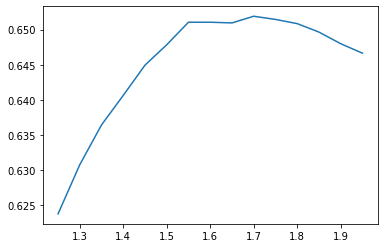

In [19]:
x=np.arange(1.25,2,0.05)
y=result
plt.plot(x,y)

In [20]:
# threshold of 1.6 is the best on validation data. That is to take about 67% of the popular books to predict 1.
# the accuracy is increased to 0.6519

In [21]:
# Q3: Jacard Similarity

In [238]:
# traindataset
traindat=traindata.to_dict(orient='records')
validat=validata.to_dict(orient='records')

In [239]:
usersPerItem = defaultdict(set)
itemsPerUser = defaultdict(set)

for d in traindat:
    user,item = d['userID'], d['bookID']
    usersPerItem[item].add(user)
    itemsPerUser[user].add(item)

In [24]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    return numer / denom




In [25]:
# picked a book that is read, the max Jaccard is 0.026. So this is one reference to set the benchmark of Jaccard.
u=valinew['userID'][0]
b=valinew['bookID'][0]
simlist=[]
rb=itemsPerUser[u] #the book the user read in traindat
user_b=usersPerItem[b] #the users read the book in traindat

In [26]:
userlist=[]
for book in rb:
    if book==b:continue
    users=usersPerItem[book]
    userlist.append(users)

In [27]:
simlist=[]
for i in range(len(userlist)):
    sim=Jaccard(userlist[i],user_b)
    simlist.append(sim)
max(simlist)

0.02631578947368421

In [28]:
def mostSimilar(u,b,threshold): 
    simlist=[]
    rb=itemsPerUser[u] #the book the user read in traindat
    user_b=usersPerItem[b]
    userlist=[]
    for book in rb:
        if book==b:continue
        users=usersPerItem[book]
        userlist.append(users)
    for i in range(len(userlist)):
        sim=Jaccard(userlist[i],user_b)
        simlist.append(sim)
    if max(simlist)>threshold:
        prediction=1
    else:
        prediction=0
    return prediction

In [30]:
def threshold(p):
    prelist=[]
    for i in range(len(valinew)):
        pred=mostSimilar(valinew['userID'][i],valinew['bookID'][i],p)
        prelist.append(pred)
    return prelist
    

In [31]:
predictlist=[]
for pa in np.arange(0.001,0.03,0.002):
    predict=threshold(pa)    
    predictlist.append(predict)


In [32]:
resultq3=[]
for j in range(len(predictlist)):
    res=sum(predictlist[j]==valinew['Read'])/20000
    resultq3.append(res)


,threshold,accuracy
5,0.011,0.62470
4,0.009,0.62120
6,0.013,0.62010
7,0.015,0.61095
3,0.007,0.61015
2,0.005,0.59910
8,0.017,0.59800
1,0.003,0.59170
0,0.001,0.59085
9,0.019,0.58335


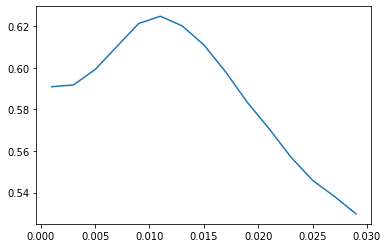

In [33]:
x=np.arange(0.001,0.03,0.002)
y=resultq3
plt.plot(x,y)
result3=pd.DataFrame({'threshold':x,'accuracy':y})
result3.sort_values(by="accuracy" , ascending=False) 

# when the threshold is 0.011, the accuracy is the best. It's 0.62

In [34]:
# Q4: Improve the above predictor by incorporating both a Jaccard-based threshold and popularity 

In [35]:
validatanew=copy.copy(valinew)

In [36]:
def maxSimilar(u,b): 
    simlist=[]
    rb=itemsPerUser[u] #the book the user read in traindat
    user_b=usersPerItem[b]
    userlist=[]
    for book in rb:
        if book==b:continue
        users=usersPerItem[book]
        userlist.append(users)
    for i in range(len(userlist)):
        sim=Jaccard(userlist[i],user_b)
        simlist.append(sim)
    return max(simlist or [0])

In [37]:
simil=[]
for i in range(20000):
    rr=maxSimilar(validatanew['userID'][i],validatanew['bookID'][i])
    simil.append(rr)

In [38]:
validatanew['similarity']=simil

validatanew # in fact, we can only use validatanew to be the traindata and validation data.

,userID,bookID,Read,similarity
0,u35176258,b30592470,1,0.026316
1,u30851063,b81941226,1,0.000000
2,u31368414,b40097012,1,0.041667
3,u71352502,b25118404,1,0.018072
4,u46986025,b89866434,1,0.027778
...,...,...,...,...
19995,u18970904,b43186214,0,0.009804
19996,u88965610,b37165101,0,0.003077
19997,u39575746,b40304083,0,0.019231
19998,u57361956,b13841563,0,0.005376


In [39]:
# book in the original split train dataset
trainbook=trainbook.rename(columns={'userID':'readtimes'})
trainbook['readprop']=trainbook['readtimes']/(0.67*len(trainbook))  # total of 7169 books, I calculate the book's read time proportion in the top 55% books.
#trainbook['logprop']=np.log(trainbook['readprop'])
trainbook

,bookID,readtimes,readprop
0,b25543219,381,0.079322
1,b76915592,319,0.066414
2,b21517939,313,0.065164
3,b75885962,273,0.056837
4,b55315814,271,0.056420
...,...,...,...
7164,b87471097,2,0.000416
7165,b26840730,2,0.000416
7166,b56184761,2,0.000416
7167,b66747010,2,0.000416


In [40]:
validatanew1=pd.merge(validatanew,trainbook,on='bookID',how='left')
validatanew1['constant']=1

In [41]:
validatanew1=validatanew1.sample(frac=1)
validatanew1=validatanew1.fillna(value=0)
validatanew1

,userID,bookID,Read,similarity,readtimes,readprop,constant
9275,u93540030,b20401770,1,0.019048,82.0,0.017072,1
9900,u23903007,b47234122,1,0.016949,31.0,0.006454,1
13515,u44308400,b79918152,0,0.013889,25.0,0.005205,1
2486,u90512832,b63466729,1,0.004902,43.0,0.008952,1
8506,u45761706,b03945041,1,0.011299,79.0,0.016447,1
...,...,...,...,...,...,...,...
6587,u73867232,b73887821,1,0.027397,9.0,0.001874,1
2609,u59799142,b26668190,1,0.034483,18.0,0.003747,1
12883,u98056115,b28308114,0,0.027778,33.0,0.006870,1
2506,u33029151,b25704142,1,0.010840,165.0,0.034352,1


In [42]:
X=validatanew1.loc[:,['constant','similarity','readprop']]
y=validatanew1.loc[:,'Read']

x_train,x_test,y_train,y_test= train_test_split(X,y,test_size=0.1,shuffle=True)

In [43]:
model = LogisticRegression(C=1000,solver="lbfgs",class_weight='balanced',max_iter=5000)
model.fit(x_train, y_train)
pred=model.predict(x_train)
pred
accuracy=sum(pred==y_train)/len(y_train)
print("the train accuracy is", accuracy)

the train accuracy is 0.6711666666666667


In [44]:
pred2=model.predict(x_test)
pred2
accuracy=sum(pred2==y_test)/len(y_test)
print("the test accuracy is", accuracy)

# I tried c=1000,the test accuracy is the highest. Then I see the accuracy on the whole validation set: It's 0.67

the test accuracy is 0.6775


In [45]:
predwholevali=model.predict(X)
accuracy=sum(predwholevali==y)/len(y)
print("the wholevalidation accuracy is", accuracy)

the wholevalidation accuracy is 0.6718


In [46]:
# Q5 To run our model on the test set

In [400]:
df=pd.read_csv(r'assignment1/pairs_Read.txt',sep='-')
df=df.rename(columns={'bookID,prediction':'bookID'})

In [7]:
ttdata=copy.copy(data)
tdata=data.to_dict(orient='records')
usersPerItem = defaultdict(set)
itemsPerUser = defaultdict(set)

In [8]:
for d in tdata:
    user,item = d['userID'], d['bookID']
    usersPerItem[item].add(user)
    itemsPerUser[user].add(item)

In [50]:
simil=[]
for i in range(len(df)):
    rr=maxSimilar(df['userID'][i],df['bookID'][i])
    simil.append(rr)

In [51]:
df['similarity']= simil

In [ ]:
ttraindata=copy.copy(data)
ttraindata=ttraindata.iloc[:,:2].groupby('bookID').count()
ttraindata.sort_values("userID",inplace=True,ascending=False)
ttraindata=ttraindata.reset_index()
ttraindata=ttraindata.rename(columns={'userID':'readtimes'})
ttraindata['readprop']=ttraindata['readtimes']/(0.67*len(ttraindata))
df=pd.merge(df,ttraindata,on='bookID',how='left')

In [53]:
df['constant']=1

In [56]:
x_testkaggle=df.loc[:,['constant','similarity','readprop']]
testpred=model.predict(x_testkaggle)

testpred

array([0, 0, 0, ..., 0, 0, 1])

In [ ]:
with open('pairs_Read.txt','r') as fa:
    with open('testpred.txt','r') as fb:
        with open('result.txt','w') as fc:
            for line in fa:
                fc.write(line.strip('\n')) 
                fc.write(fb.readline())
fc.close()

In [ ]:
#KAGGLE ID : aki

In [ ]:
# Tasks (Rating prediction)

In [240]:
#Q9  fit a model rating(user, item) ' α + βuser + βitem
traindata=data[:190000]
validata=data[190000:].reset_index()

In [241]:
N = len(traindat)
nUsers = len(itemsPerUser)
nItems = len(usersPerItem)
users = list(itemsPerUser.keys())
items = list(usersPerItem.keys())
ratingPerUser = defaultdict(list)
ratingPerItem = defaultdict(list)


In [242]:
for d in traindat:
    user,item,rating = d['userID'], d['bookID'],d['rating']
    ratingPerUser[user].append(rating)
    ratingPerItem[item].append(rating)

In [243]:
#initial set:
alpha0=0
betau0=0
betai0=0
alpha1=sum(traindata['rating'])/N

In [244]:
userBiases = defaultdict(list)
itemBiases = defaultdict(list)

In [245]:
for d in users:
    ub= (sum(ratingPerUser[d])-(alpha1+betai0)*len(ratingPerUser[d])) /(1+len(itemsPerUser[d]))
    userBiases[d].append(ub)

In [246]:
userbiastable= pd.DataFrame.from_dict(userBiases,orient='index').reset_index().rename({0:'userbias'}, axis='columns')
totalbiastable = pd.merge(traindata,userbiastable,left_on='userID',right_on='index',how='left')

In [247]:
bookbiastable=totalbiastable.groupby('bookID').apply(lambda x:sum(x.userbias)).reset_index().rename({0:'bookbias'},axis='columns')

In [248]:
bookbiasdic=bookbiastable.to_dict(orient='records')

In [249]:
bookbias= defaultdict(list)
for d in bookbiasdic:
    item,book_bias =  d['bookID'],d['bookbias']
    bookbias[item].append(book_bias)

In [388]:
#itemBiases

In [250]:
for d in items:
    bookbeta= (sum(ratingPerItem[d])-(alpha1*len(ratingPerItem[d])+sum(bookbias[d]))) /(1+len(usersPerItem[d]))
    itemBiases[d].append(bookbeta)
 

In [251]:
itemBiasestable= pd.DataFrame.from_dict(itemBiases,orient='index').reset_index().rename({0:'itembias'}, axis='columns')

In [252]:
itemBiasestable= pd.DataFrame.from_dict(itemBiases,orient='index').reset_index().rename({0:'itembias'}, axis='columns')
totalbiastable2 = pd.merge(totalbiastable,itemBiasestable,left_on='bookID',right_on='index',how='left')

In [253]:
totalbiastable2['pre']=alpha1+totalbiastable2['itembias']+ totalbiastable2['userbias']

In [254]:
MSE1=sum((totalbiastable2['pre']-totalbiastable2['rating'])**2)/len(totalbiastable2)

In [255]:
MSE1  # 1st set end

0.9132920702423193

In [256]:
#2nd set
totalreal=sum(traindata['rating'])
totalbetai=sum([sum(x) for x in itemBiases.values()])
totalbetau=sum([sum(x) for x in userBiases.values()])
alpha2=(totalreal-(totalbetau+totalbetai))/N
userBiases2 = defaultdict(list)
sumItembiasPerUser=defaultdict(list)

In [257]:
for d in users:
    bi=[]
    for i in itemsPerUser[d]:
        b=itemBiases[i]
        bi.append(b)
        res=sum([sum(x) for x in bi])
    sumItembiasPerUser[d].append(res)

In [258]:
userBiases2 = defaultdict(list)
for d in users:
    ub= (sum(ratingPerUser[d])-(alpha2*len(ratingPerUser[d])+sum(sumItembiasPerUser[d]))) /(1+len(itemsPerUser[d]))
    userBiases2[d].append(ub)

In [259]:
sumUserbiasPerItem=defaultdict(list)
itemBiases2 = defaultdict(list)
for d in items:
    bu=[]
    for i in usersPerItem[d]:
        b=userBiases2[i]
        bu.append(b)
        res=sum([sum(x) for x in bu])
    sumUserbiasPerItem[d].append(res)
for d in items:
    ui= (sum(ratingPerItem[d])-(alpha2*len(ratingPerItem[d])+sum(sumUserbiasPerItem[d]))) /(1+len(usersPerItem[d]))
    itemBiases2[d].append(ui)


In [260]:
def prediction(user,item):
    pred=sum(userBiases2[user])+sum(itemBiases2[item])+alpha2
    return pred

In [261]:
predictions=[]
for i in range(len(traindat)):
    predictions.append(prediction(traindata.userID[i],traindata.bookID[i]))

In [262]:
labels = [d['rating'] for d in traindat]

In [263]:
def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

In [264]:
MSE2=MSE(predictions,labels)
MSE2  # 2nd set end MSEdecreased

0.9048912326893028

In [ ]:
# write a loop of the iteration until convergence:

In [356]:
itemBiases_ite=copy.copy(itemBiases2)
userBiases_ite=copy.copy(userBiases2)

In [357]:
def predictor(alphai,userBiasesi,itemBiasesi,user,item):
    pred=sum(userBiasesi[user])+sum(itemBiasesi[item])+alphai
    return pred
def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

In [358]:
ttbi=[]
ttbu=[]
alplist=[]
itemBiases_ite=[itemBiases_ite]
userBiases_ite=[userBiases_ite]
MSElist=[]
predictlist=[]
for i in range(20):   
    totalbetai=sum([sum(x) for x in itemBiases_ite[i].values()])
    ttbi.append(totalbetai)
    totalbetau=sum([sum(x) for x in userBiases_ite[i].values()])
    ttbu.append(totalbetau)
    alpha=(totalreal-(ttbi[i]+ttbu[i]))/N
    alplist.append(alpha)

    sumItembiasPerUser_ite=defaultdict(list)
    for d in users:
        bi=[]
        for j in itemsPerUser[d]:
            b=itemBiases_ite[i][j]
            bi.append(b)
            res=sum([sum(x) for x in bi])
        sumItembiasPerUser_ite[d].append(res)    
        
    userBiases_add=defaultdict(list)
    for d in users:
        ub= (sum(ratingPerUser[d])-(alplist[i]*len(ratingPerUser[d])+sum(sumItembiasPerUser_ite[d]))) /(1+len(itemsPerUser[d]))
        userBiases_add[d].append(ub)
    userBiases_ite.append(userBiases_add)

    sumUserbiasPerItem_ite=defaultdict(list)
    for d in items:
        bu=[]
        for j in usersPerItem[d]:
            b=userBiases_ite[i][j]
            bu.append(b)
            res=sum([sum(x) for x in bu])
        sumUserbiasPerItem_ite[d].append(res)

    itemBiases_add=defaultdict(list)
    for d in items:
        ui= (sum(ratingPerItem[d])-(alplist[i]*len(ratingPerItem[d])+sum(sumUserbiasPerItem_ite[d]))) /(1+len(usersPerItem[d]))
        itemBiases_add[d].append(ui)
    itemBiases_ite.append(itemBiases_add)

    predictions=[]
    for l in range(len(traindat)):
        m=i+1
        predictions.append(predictor(alplist[i],userBiases_ite[m],itemBiases_ite[m],traindata.userID[l],traindata.bookID[l]))
    predictlist.append(predictions)
    MSEresult=MSE(predictlist[i],labels)
    MSElist.append(MSEresult)
    print(str(i)+".MSE:"+str(MSElist[i]))


0.MSE:0.9044485644908073
1.MSE:0.9042751694879395
2.MSE:0.9041529137108026
3.MSE:0.9041144750744964
4.MSE:0.9040641106131933
5.MSE:0.9040535453293465
6.MSE:0.9040288617966485
7.MSE:0.9040262314637156
8.MSE:0.9040127855079181
9.MSE:0.9040127307380699
10.MSE:0.904004882642293
11.MSE:0.9040056518319599
12.MSE:0.9040008434340683
13.MSE:0.9040017990408088
14.MSE:0.9039987403483056
15.MSE:0.9039996448445201
16.MSE:0.9039976373335346
17.MSE:0.9039984115121805
18.MSE:0.9039970579558116
19.MSE:0.9039976877587743


In [ ]:
# Including the first 2 sets of beta and alpha, the MSE on train dataset is stable after 20 times iteration. We use the 19th time's beta to predict validation data.

In [359]:
predictvali=[]
for i in range(len(validata)):
    predictvali.append(predictor(alplist[18],userBiases_ite[19],itemBiases_ite[19],validata.userID[i],validata.bookID[i]))
valilabels=[d['rating'] for d in validat]
MSEvali=MSE(predictvali,valilabels)

In [360]:
print("MSE on validation data is:" + str(MSEvali))

MSE on validation data is:1.1159847209829463


In [417]:
itemBiases_ite[19].pop('b21479253')

In [322]:
# Q10:Report the user and book IDs that have the largest and smallest values of β (1 mark).


In [370]:
itembetas= pd.DataFrame.from_dict(itemBiases_ite[19],orient='index').reset_index().rename({0:'itembias'},axis='columns')

In [371]:
itembetas.sort_values(by='itembias')

,index,itembias
5387,b84091840,-1.815699
4252,b84593887,-1.640213
1591,b31585810,-1.487344
6161,b58062803,-1.462104
6809,b21117330,-1.460714
...,...,...
6013,b43938572,0.959497
2900,b99517795,0.973519
976,b47216584,0.985815
357,b47166041,1.068403


In [372]:
print("the book with largest beta is:b19925500 , the beta is 1.3667")
print("the book with smallest beta is:b84091840 , the beta is -1.81")

the book with largest beta is:b19925500 , the beta is 1.3667
the book with smallest beta is:b84091840 , the beta is -1.81


In [373]:
largest_userid=max(userBiases_ite[19],key=userBiases_ite[19].get)
smallest_userid=min(userBiases_ite[19],key=userBiases_ite[19].get)


In [374]:
print("the user with largest beta is:"+largest_userid+" the beta is "+ str(userBiases_ite[19][largest_userid][0]))
print("the user with smallest beta is:"+smallest_userid+" the beta is "+ str(userBiases_ite[19][smallest_userid][0]))

the user with largest beta is:u32162993 the beta is 1.2968957367242602
the user with smallest beta is:u48313610 the beta is -3.7737730310865554


In [ ]:
# Q11 Find a better value of λ using your validation set. 
# Report the value you chose, its MSE

In [402]:
def lambda_(lamb):
    itemBiases_ite=copy.copy(itemBiases2)
    userBiases_ite=copy.copy(userBiases2)
    ttbi=[]
    ttbu=[]
    alplist=[]
    itemBiases_ite=[itemBiases_ite]
    userBiases_ite=[userBiases_ite]
    MSElist=[]
    predictlist=[]

    for i in range(20):   
        totalbetai=sum([sum(x) for x in itemBiases_ite[i].values()])
        ttbi.append(totalbetai)
        totalbetau=sum([sum(x) for x in userBiases_ite[i].values()])
        ttbu.append(totalbetau)
        alpha=(totalreal-(ttbi[i]+ttbu[i]))/N
        alplist.append(alpha)

        sumItembiasPerUser_ite=defaultdict(list)
        for d in users:
            bi=[]
            for j in itemsPerUser[d]:
                b=itemBiases_ite[i][j]
                bi.append(b)
                res=sum([sum(x) for x in bi])
            sumItembiasPerUser_ite[d].append(res)    

        userBiases_add=defaultdict(list)
        for d in users:
            ub= (sum(ratingPerUser[d])-(alplist[i]*len(ratingPerUser[d])+sum(sumItembiasPerUser_ite[d]))) /(lamb+len(itemsPerUser[d]))
            userBiases_add[d].append(ub)
        userBiases_ite.append(userBiases_add)

        sumUserbiasPerItem_ite=defaultdict(list)
        for d in items:
            bu=[]
            for j in usersPerItem[d]:
                b=userBiases_ite[i][j]
                bu.append(b)
                res=sum([sum(x) for x in bu])
            sumUserbiasPerItem_ite[d].append(res)

        itemBiases_add=defaultdict(list)
        for d in items:
            ui= (sum(ratingPerItem[d])-(alplist[i]*len(ratingPerItem[d])+sum(sumUserbiasPerItem_ite[d]))) /(lamb+len(usersPerItem[d]))
            itemBiases_add[d].append(ui)
        itemBiases_ite.append(itemBiases_add)

        predictions=[]
        for l in range(len(validata)):
            m=i+1
            predictions.append(predictor(alplist[i],userBiases_ite[m],itemBiases_ite[m],validata.userID[l],validata.bookID[l]))
        predictlist.append(predictions)
        MSEresult=MSE(predictlist[i],valilabels)
        MSElist.append(MSEresult)
        #print(str(i)+".MSE:"+str(MSElist[i]))
    return [lamb,min(MSElist),MSElist.index(min(MSElist))]


In [392]:
resultq11=[]
for l in range(7):
    resultq11.append(lambda_(l))

In [396]:
resultq11

[[0, 1.1286596342002426],
 [1, 1.1159840040266273],
 [2, 1.1098536293204382],
 [3, 1.1074512148093125],
 [4, 1.107545395997351],
 [5, 1.109304768243921],
 [6, 1.1121928753702082]]

In [ ]:
# The value I chose is 3, its MSE=1.107

In [403]:
lambda_(3)

[3, 1.1074512148093125, 0]

In [406]:
#load data
testdata=pd.read_csv(r'assignment1/pairs_Rating.txt',sep='-')
testdata=testdata.rename(columns={'bookID,prediction':'bookID'})

In [407]:
testdata

,userID,bookID
0,u39027358,b98920686
1,u50800253,b93497672
2,u07295538,b19850286
3,u41427072,b39758017
4,u89648987,b25118404
...,...,...
9995,u78346778,b73812430
9996,u71616100,b10876672
9997,u64609829,b62615825
9998,u28944466,b02268479


In [408]:
testrating=[]
for l in range(len(testdata)):
    m=i+1
    testrating.append(predictor(alplist[0],userBiases_ite[1],itemBiases_ite[1],testdata.userID[l],testdata.bookID[l]))


In [411]:
testdata['prediction']=testrating
testdata

,userID,bookID,prediction
0,u39027358,b98920686,4.160537
1,u50800253,b93497672,4.315733
2,u07295538,b19850286,3.989231
3,u41427072,b39758017,4.043435
4,u89648987,b25118404,4.585312
...,...,...,...
9995,u78346778,b73812430,4.592028
9996,u71616100,b10876672,4.288928
9997,u64609829,b62615825,3.958759
9998,u28944466,b02268479,4.829524


In [414]:
f=open("predictions_Rating.txt", 'w')

In [415]:
for index, (userID, bookID, prediction) in testdata.iterrows():
    f.write('{}-{},{}\n'.format(userID, bookID, float(prediction)))

In [416]:
f.close()

In [ ]:
#KAGGLE ID : aki